#### 1. Loading dataset

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-08-01 22:00:15.419515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 22:00:16.519204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-08-01 22:00:16.519329: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [27]:
from sklearn.datasets import fetch_lfw_pairs

lfw_dataset_train = fetch_lfw_pairs(subset='train',color=True,resize = 1)
lfw_dataset_test = fetch_lfw_pairs(subset='test',color=True, resize = 1)

In [28]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [29]:
X_train = lfw_dataset_train.pairs
y_train = lfw_dataset_train['target']

X_test = lfw_dataset_test.pairs
y_test = lfw_dataset_test['target']

In [30]:
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

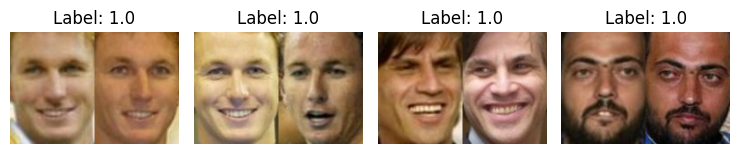

In [31]:
visualize(X_train[:-1], y_train[:-1], to_show=4, num_col=4)

In [32]:
X_train.shape

(2200, 2, 125, 94, 3)

In [33]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((125, 94, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((125, 94, 1))
input_2 = layers.Input((125, 94, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [34]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [35]:
margin = 1  # Margin for contrastive loss.
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
siamese.compile(loss=loss(margin=margin), optimizer=opt, metrics=["accuracy"])
siamese.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 125, 94, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 125, 94, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_2 (Functional)           (None, 10)           127174      ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [36]:
# Convert RGB to grayscale
X_train_gray = np.dot(X_train[..., :3], [0.2989, 0.5870, 0.1140])

# Expand the dimensions to have the shape (2200, 62, 47, 1)
X_train_gray = np.expand_dims(X_train_gray, axis=-1)

X_train_gray = np.squeeze(X_train_gray, axis=-1)

X_train_gray.shape

(2200, 2, 125, 94)

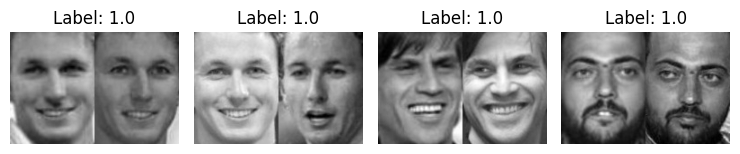

In [37]:
visualize(X_train_gray[:-1], y_train[:-1], to_show=4, num_col=4)

In [38]:
# Convert RGB to grayscale
X_test_gray = np.dot(X_test[..., :3], [0.2989, 0.5870, 0.1140])

# Expand the dimensions to have the shape (2200, 62, 47, 1)
X_test_gray = np.expand_dims(X_test_gray, axis=-1)

X_test_gray = np.squeeze(X_test_gray, axis=-1)

X_test_gray.shape

(1000, 2, 125, 94)

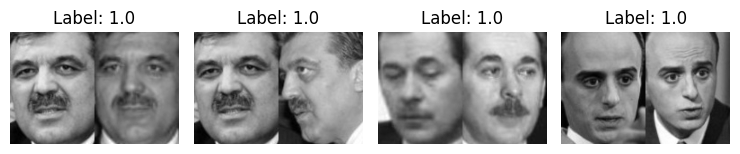

In [39]:
visualize(X_test_gray[:-1], y_test[:-1], to_show=4, num_col=4)

In [40]:
x_train_1 = X_train_gray[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = X_train_gray[:, 1]

x_test_1 = X_test_gray[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_test_2 = X_test_gray[:, 1]

In [41]:
x_train_1.shape, x_test_1.shape, x_train_2.shape, x_test_2.shape

((2200, 125, 94), (1000, 125, 94), (2200, 125, 94), (1000, 125, 94))

In [42]:
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback

model_path = os.path.join("weights", "siamese_image_similarity.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

In [43]:
epochs = 30
batch_size = 64

In [44]:
with tf.device('/GPU:0'):
    history = siamese.fit(
        [x_train_1, x_train_2],
        y_train,
        validation_data=([x_test_1, x_test_2], y_test),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[reduceLROnPlato, checkPoint]
    )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


35/35 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.4409
Epoch 1: val_loss improved from inf to 0.28557, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 192ms/step - loss: 0.3078 - accuracy: 0.4409 - val_loss: 0.2856 - val_accuracy: 0.4420 - lr: 0.0100
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.4568
Epoch 2: val_loss improved from 0.28557 to 0.26807, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 185ms/step - loss: 0.2701 - accuracy: 0.4568 - val_loss: 0.2681 - val_accuracy: 0.4220 - lr: 0.0100
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.4618
Epoch 3: val_loss improved from 0.26807 to 0.25874, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 175ms/step - loss: 0.2565 - accuracy: 0.4618 - val_loss: 0.2587 - val_accuracy: 0.4340 - lr: 0.0100
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.4618
Epoch 4: val_loss improved from 0.25874 to 0.25280, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 189ms/step - loss: 0.2526 - accuracy: 0.4618 - val_loss: 0.2528 - val_accuracy: 0.4710 - lr: 0.0100
Epoch 5/30
35/35 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.4614
Epoch 5: val_loss improved from 0.25280 to 0.25106, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 180ms/step - loss: 0.2512 - accuracy: 0.4614 - val_loss: 0.2511 - val_accuracy: 0.4680 - lr: 0.0100
Epoch 6/30
35/35 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.4705
Epoch 6: val_loss improved from 0.25106 to 0.25036, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 188ms/step - loss: 0.2505 - accuracy: 0.4705 - val_loss: 0.2504 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 7/30
35/35 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.4959
Epoch 7: val_loss improved from 0.25036 to 0.24966, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 179ms/step - loss: 0.2501 - accuracy: 0.4959 - val_loss: 0.2497 - val_accuracy: 0.5340 - lr: 0.0100
Epoch 8/30
35/35 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.5100
Epoch 8: val_loss improved from 0.24966 to 0.24922, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 189ms/step - loss: 0.2499 - accuracy: 0.5100 - val_loss: 0.2492 - val_accuracy: 0.5440 - lr: 0.0100
Epoch 9/30
35/35 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.5168
Epoch 9: val_loss improved from 0.24922 to 0.24870, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 178ms/step - loss: 0.2495 - accuracy: 0.5168 - val_loss: 0.2487 - val_accuracy: 0.5300 - lr: 0.0100
Epoch 10/30
35/35 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.5405
Epoch 10: val_loss improved from 0.24870 to 0.24815, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 191ms/step - loss: 0.2487 - accuracy: 0.5405 - val_loss: 0.2482 - val_accuracy: 0.5230 - lr: 0.0100
Epoch 11/30
35/35 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.5514
Epoch 11: val_loss improved from 0.24815 to 0.24783, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 181ms/step - loss: 0.2482 - accuracy: 0.5514 - val_loss: 0.2478 - val_accuracy: 0.5380 - lr: 0.0100
Epoch 12/30
35/35 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.5386
Epoch 12: val_loss improved from 0.24783 to 0.24772, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 189ms/step - loss: 0.2473 - accuracy: 0.5386 - val_loss: 0.2477 - val_accuracy: 0.5250 - lr: 0.0100
Epoch 13/30
35/35 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.5523
Epoch 13: val_loss improved from 0.24772 to 0.24763, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 179ms/step - loss: 0.2474 - accuracy: 0.5523 - val_loss: 0.2476 - val_accuracy: 0.5400 - lr: 0.0100
Epoch 14/30
35/35 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.5545
Epoch 14: val_loss improved from 0.24763 to 0.24634, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 188ms/step - loss: 0.2459 - accuracy: 0.5545 - val_loss: 0.2463 - val_accuracy: 0.5470 - lr: 0.0100
Epoch 15/30
35/35 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.5677
Epoch 15: val_loss improved from 0.24634 to 0.24613, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 190ms/step - loss: 0.2439 - accuracy: 0.5677 - val_loss: 0.2461 - val_accuracy: 0.5480 - lr: 0.0100
Epoch 16/30
35/35 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.5655
Epoch 16: val_loss improved from 0.24613 to 0.24393, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 192ms/step - loss: 0.2433 - accuracy: 0.5655 - val_loss: 0.2439 - val_accuracy: 0.5530 - lr: 0.0100
Epoch 17/30
35/35 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.5832
Epoch 17: val_loss did not improve from 0.24393
35/35 [==============================] - 4s 113ms/step - loss: 0.2418 - accuracy: 0.5832 - val_loss: 0.2441 - val_accuracy: 0.5630 - lr: 0.0100
Epoch 18/30
35/35 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.5791
Epoch 18: val_loss did not improve from 0.24393
35/35 [==============================] - 3s 99ms/step - loss: 0.2419 - accuracy: 0.5791 - val_loss: 0.2463 - val_accuracy: 0.5780 - lr: 0.0100
Epoch 19/30
35/35 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.5777
Epoch 19: val_loss did not improve from 0.24393
35/35 [==============================] - 3s 100ms/step - loss: 0.2418 - accuracy: 0.5777 - val_loss: 0.2469 - val_accuracy: 0.5450 - lr: 0.0

INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 8s 219ms/step - loss: 0.2417 - accuracy: 0.5827 - val_loss: 0.2403 - val_accuracy: 0.5910 - lr: 0.0100
Epoch 22/30
35/35 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.5800
Epoch 22: val_loss improved from 0.24025 to 0.23909, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 7s 190ms/step - loss: 0.2425 - accuracy: 0.5800 - val_loss: 0.2391 - val_accuracy: 0.5940 - lr: 0.0100
Epoch 23/30
35/35 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.5836
Epoch 23: val_loss improved from 0.23909 to 0.23798, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 179ms/step - loss: 0.2416 - accuracy: 0.5836 - val_loss: 0.2380 - val_accuracy: 0.6020 - lr: 0.0100
Epoch 24/30
35/35 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.5836
Epoch 24: val_loss improved from 0.23798 to 0.23773, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 188ms/step - loss: 0.2411 - accuracy: 0.5836 - val_loss: 0.2377 - val_accuracy: 0.6090 - lr: 0.0100
Epoch 25/30
35/35 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.5864
Epoch 25: val_loss improved from 0.23773 to 0.23742, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


35/35 [==============================] - 6s 179ms/step - loss: 0.2416 - accuracy: 0.5864 - val_loss: 0.2374 - val_accuracy: 0.5990 - lr: 0.0100
Epoch 26/30
35/35 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.5841
Epoch 26: val_loss did not improve from 0.23742
35/35 [==============================] - 3s 96ms/step - loss: 0.2419 - accuracy: 0.5841 - val_loss: 0.2389 - val_accuracy: 0.6010 - lr: 0.0100
Epoch 27/30
35/35 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.5750
Epoch 27: val_loss did not improve from 0.23742
35/35 [==============================] - 3s 96ms/step - loss: 0.2420 - accuracy: 0.5750 - val_loss: 0.2420 - val_accuracy: 0.5800 - lr: 0.0100
Epoch 28/30
35/35 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.5859
Epoch 28: val_loss did not improve from 0.23742
35/35 [==============================] - 3s 95ms/step - loss: 0.2402 - accuracy: 0.5859 - val_loss: 0.2435 - val_accuracy: 0.5720 - lr: 0.010

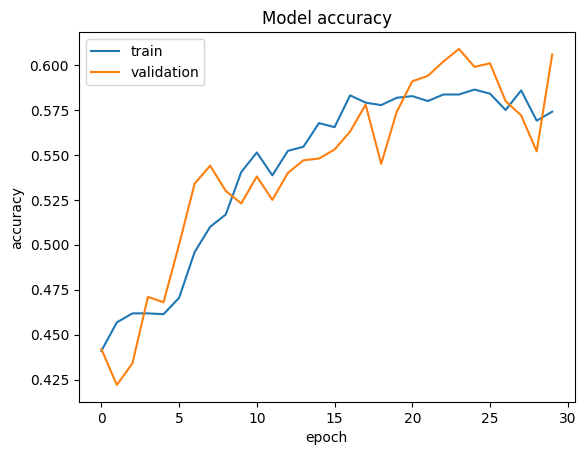

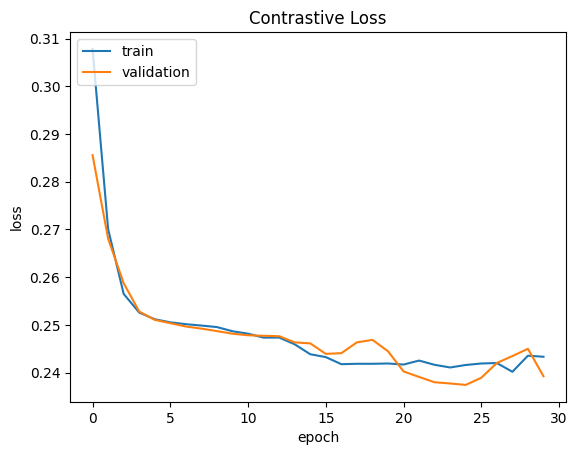

In [45]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")


In [46]:
results = siamese.evaluate([x_test_1, x_test_2], y_test)
print("test loss, test acc:", results)

 1/32 [..............................] - ETA: 2s - loss: 0.2489 - accuracy: 0.5625

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 1s 23ms/step - loss: 0.2392 - accuracy: 0.6060
test loss, test acc: [0.23924382030963898, 0.6060000061988831]


32/32 [==============================] - 0s 14ms/step


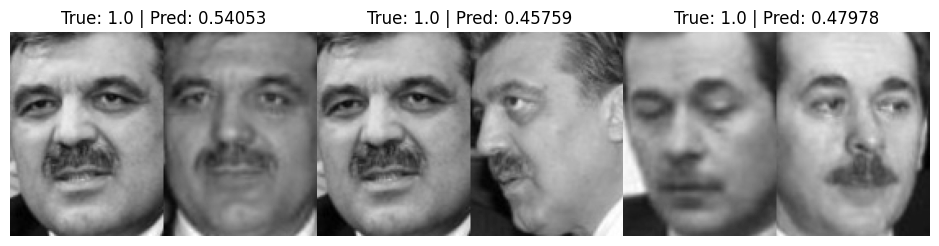

In [47]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(X_test_gray, y_test, to_show=5, predictions=predictions, test=True)

In [48]:
a = []
for i in predictions:
    if i[0] >= 0.5:
        a.append(float(1))
    else:
        a.append(float(0))

In [49]:
pred = np.array(a)

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names


print(classification_report(pred, y_test, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.63      0.60      0.61       522
      Same person       0.58      0.61      0.60       478

         accuracy                           0.61      1000
        macro avg       0.61      0.61      0.61      1000
     weighted avg       0.61      0.61      0.61      1000

